## Predicting maintenance required:

A random forest with 5-fold cross validation for hyperparameter tuning was trained on C138 TRC + GPR data, with the aim of predicting maintenance works that occured before the next track recording date. Since track maintenance occurred infrequently across the track, the data was downsampled to provide equal representation of track maintenance or having no maintenance. 

50% of data was partitioned for train and test, while a hold-out set comprising recordings made on: '2018-06-26', '2015-05-15', '2016-06-03', '2019-02-07' for C138, and all recordings for C195, were used to measure model accuracy. This hold-out set was designed to simulate engineers feeding new TRC data into the algorithm for predictions, as opposed to having a pre-balanced set of data. 

Using TRC + GPR data, a random forest achieved 87.4% predictive accuracy (84.9% precision, 89.6% recall) on unseen balanced test data. When using this algorithm on full track recording (non-balanced) however, accuracy dropped to 65% on C138 TRC, and 54% on C195 data.

In [18]:
import pandas as pd
import numpy as np
from ast import literal_eval
import pickle
from utils import paths
import os
from sklearn.utils import resample
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

In [6]:
df = pd.read_csv(os.path.join(paths.DATA, 'combined_138.csv'))

j:\shared\omsa\sem3\dva\lib\site-packages\IPython\core\interactiveshell.py:3058: DtypeWarning: Columns (26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,42,43,45,46,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,73,74,75,76) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [7]:
df.columns

Index(['Unnamed: 0', 'METRAGE', 'Date', 'AC LN', 'AC VT', 'CON F', 'GAUGE',
       'GR HT', 'OV HT', 'SUPER', 'TOP L', 'TOP R', 'TR ST', 'TW 10', 'TW 3',
       'VER L', 'VER R', 'VOLT', 'Track_code', 'Work_orders',
       'Work_order_type', 'culvert', 'speed_description',
       'speed_char_val_from', 'speed_char_val_to', 'speed_value_units',
       'Category', 'Category.1', 'Category.2', 'Category.3', 'Category.4',
       'Category.5', 'Category.6', 'Category.7', 'Category.8', 'Centre',
       'Centre.1', 'Centre.2', 'Centre.3', 'Centre.4', 'Centre.5',
       'Collection Date', 'Dec.Lat', 'Dec.Long', 'Division', 'End KM',
       'GPR Run Number', 'Geolink', 'Laser Run number', 'Left*', 'Left*.1',
       'Left*.2', 'Left*.3', 'Left*.4', 'Left*.5', 'Line Segment', 'Mudspot',
       'PVC Value', 'PVC Value.1', 'PVC Value.2', 'Prefix', 'Right', 'Right*',
       'Right*.1', 'Right*.2', 'Right*.3', 'Right*.4', 'Right.1', 'Right.2',
       'Right.3', 'Sleeper_type', 'Start KM', 'Sub-divisio

In [8]:
measures = ['AC LN', 'AC VT', 'CON F', 'GAUGE',
       'GR HT', 'OV HT', 'SUPER', 'TOP L', 'TOP R', 'TR ST', 'TW 10', 'TW 3',
       'VER R', 'VOLT', 'culvert', 'Centre',
       'Centre.1', 'Centre.2', 'Centre.3', 'Centre.4', 'Centre.5','Left*', 'Left*.1',
       'Left*.2', 'Left*.3', 'Left*.4', 'Left*.5','Mudspot',
       'PVC Value', 'PVC Value.1', 'PVC Value.2', 'Right', 'Right*',
       'Right*.1', 'Right*.2', 'Right*.3', 'Right*.4', 'Right.1', 'Right.2',
       'Right.3', 'Sleeper_type','Volume (cubic m)', 'Volume (cubic m).1', 'Volume (cubic m).2']

In [23]:
## import pickled model
with open(os.path.join(paths.MODELS, 'rf_cv_wo.pickle'), 'rb') as f:
    model = pickle.load(f)

In [9]:
def presence_of_wo(x):
    num_wo = len(literal_eval(x))
    if num_wo >0:
        ans = 1
    else:
        ans = 0
    return ans

df['has_wo'] = df['Work_order_type'].apply(lambda x: presence_of_wo(x))

In [10]:
def contains_ballast(x):
    workorders = literal_eval(x)
    ans = 0
    for work in workorders:
        if 'ballast' in work.lower():
            ans = 1
    return ans

df['Ballast_work'] = df['Work_order_type'].apply(lambda x: contains_ballast(x))

In [15]:
len(df[df['has_wo']==1])

423666

In [95]:
df['Date'].unique()

array(['2016-10-10', '2017-01-20', '2017-07-13', '2018-02-10',
       '2018-06-26', '2018-10-03', '2019-02-06', '2014-02-14',
       '2017-10-25', '2015-05-15', '2016-01-30', '2016-06-03',
       '2015-10-02', '2014-06-04', '2014-10-31', '2017-10-17',
       '2017-01-31', '2016-09-27', '2017-07-04', '2019-01-30',
       '2018-01-30', '2018-06-19', '2014-02-11', '2016-05-30',
       '2015-02-05', '2015-05-25', '2014-05-16', '2017-06-22',
       '2016-02-02', '2015-11-09', '2016-10-11', '2019-03-04',
       '2014-10-04', '2017-02-09', '2018-01-19', '2018-10-12',
       '2019-01-17', '2018-06-14', '2016-09-09', '2014-01-31',
       '2016-05-16', '2016-02-29', '2015-01-20', '2018-09-29',
       '2019-02-07', '2015-02-10', '2018-10-23', '2015-02-06'],
      dtype=object)

In [11]:
## test on some dates (holdout set)
test_set = df.loc[(df['Date']== '2018-06-26') | (df['Date']== '2015-05-15') | (df['Date'] == '2016-06-03')| (df['Date'] =='2019-02-07')]
train_set = df.loc[~((df['Date']== '2018-06-26') | (df['Date']== '2015-05-15') | (df['Date'] == '2016-06-03')| (df['Date'] =='2019-02-07'))]

In [12]:


df_noB = train_set[train_set['has_wo']==0]
df_B = train_set[train_set['has_wo']==1]

downsampled_noB = resample(df_noB, replace = True, n_samples = len(train_set[train_set['has_wo']==1]))
downsampled_B = resample(df_B, replace = True, n_samples = len(train_set[train_set['has_wo']==1]))

downsampled_df = pd.concat([downsampled_noB,downsampled_B])


In [13]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(downsampled_df[measures], downsampled_df['has_wo'], test_size=0.5, random_state=0)

In [14]:
for col in X_train.columns:
    X_train[col] = pd.to_numeric(X_train[col], errors='coerce')
    
for col in X_train.columns:
    X_test[col] = pd.to_numeric(X_test[col], errors='coerce')
    
X_train = X_train.fillna(0)
X_test = X_test.fillna(0)

In [15]:
## Logistic regression
LR = LogisticRegression().fit(X_train, y_train)
LR_pred = LR.predict(X_train)
LR_acc = metrics.accuracy_score(LR_pred, y_train)
print(LR_acc)

j:\shared\omsa\sem3\dva\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


0.6102477530632474


In [16]:
LR_recall = metrics.recall_score(LR_pred, y_train)
LR_precision = metrics.precision_score(LR_pred, y_train)
LR_f1 = metrics.f1_score(LR_pred, y_train)
print(LR_recall, LR_precision, LR_f1)

0.6218123466580754 0.5585217091277394 0.588470175726624


In [19]:
## SVM
sv = SVC().fit(X_train, y_train)
sv_pred = LR.predict(X_train)
sv_acc = metrics.accuracy_score(LR_pred, y_train)
print(sv_acc)

j:\shared\omsa\sem3\dva\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


0.6102477530632474


In [20]:
sv_recall = metrics.recall_score(sv_pred, y_train)
sv_precision = metrics.precision_score(sv_pred, y_train)
sv_f1 = metrics.f1_score(sv_pred, y_train)
print(sv_recall, sv_precision, sv_f1)

0.6218123466580754 0.5585217091277394 0.588470175726624


In [101]:
## Random Forest
rf = RandomForestClassifier().fit(X_train, y_train)
rf_pred = rf.predict(X_train)
rf_acc = metrics.accuracy_score(rf_pred, y_train)
print(rf_acc)

j:\shared\omsa\sem3\dva\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


0.9960989235250183


In [102]:
rf_test_pred = rf.predict(X_test.fillna(0))
rf_test_acc = metrics.accuracy_score(rf_test_pred, y_test)

print(rf_test_acc)

0.8746879832961736


In [103]:
feat_importance = rf.feature_importances_
indices = np.argsort(feat_importance)[::-1]
print('Sorted feature importance:')
print(sorted(feat_importance, reverse = True))

print('Fetaure number')
print(indices.tolist())

Sorted feature importance:
[0.07209011860545742, 0.07043307535595203, 0.06403661701291066, 0.054233528836064346, 0.05063021619463879, 0.05062863855986849, 0.04801327872474746, 0.04582353825535554, 0.045237525651076686, 0.0420087029733591, 0.04051074690718691, 0.0395767095111975, 0.038232927143229026, 0.037354743932338265, 0.03489273780882376, 0.03318472258943477, 0.03285922365309795, 0.03126920621544188, 0.030446743314181506, 0.026568582485230537, 0.02081146087077642, 0.009656137459546651, 0.009563609122642341, 0.009108207552875955, 0.008891609670838354, 0.008805092938179906, 0.0066871774767628105, 0.006085366747940232, 0.0057941057139379035, 0.005581272773878243, 0.005445830582897869, 0.005097182596541407, 0.004538497141607167, 0.0038002613411644544, 0.0010793355788373687, 0.0010232687019803197, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
Fetaure number
[13, 6, 5, 3, 2, 0, 12, 1, 41, 4, 42, 9, 10, 43, 8, 11, 7, 28, 30, 29, 25, 36, 32, 15, 21, 18, 35, 23, 34, 24, 22, 16, 33, 17, 14, 27, 20

In [104]:
measures[13]

'VOLT'

In [105]:
rf_cm = metrics.confusion_matrix(rf_test_pred, y_test)
rf_cm

array([[161822,  27260],
       [ 17872, 153203]], dtype=int64)

In [106]:
metrics.recall_score(rf_test_pred, y_test)

0.8955311997661844

In [107]:
metrics.precision_score(rf_test_pred, y_test)

0.8489441048857661

j:\shared\omsa\sem3\dva\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


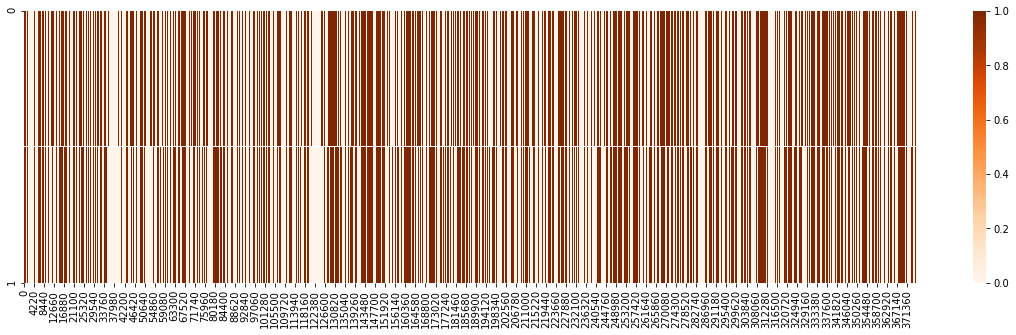

In [79]:
## Test performance for RF
fig, ax = plt.subplots(figsize = (20,5))
ax = sns.heatmap(pd.DataFrame(rf_test_pred,y_test).reset_index().as_matrix().T, cmap = 'Oranges')
plt.show()


In [19]:
## now predict on holdout set
### Prep data
x_test_set = test_set[measures]
y_test_set = test_set['has_wo']

for col in x_test_set.columns:
    x_test_set[col] = pd.to_numeric(x_test_set[col], errors='coerce')

x_test_set = x_test_set.fillna(0)

j:\shared\omsa\sem3\dva\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


In [24]:
# prepdata
rf_pred_full = model.predict(x_test_set)
rf_acc = metrics.accuracy_score(rf_pred_full, test_set['has_wo'])
print(rf_acc)

0.7186729599484645


In [109]:
# prepdata
rf_pred_full = rf.predict(x_test_set)
rf_acc = metrics.accuracy_score(rf_pred_full, test_set['has_wo'])
print(rf_acc)

0.6525191709716183


In [25]:
rf_cm = metrics.confusion_matrix(rf_pred_full, test_set['has_wo'])
rf_cm

array([[13181, 18678],
       [ 4031, 44831]], dtype=int64)

In [26]:
metrics.precision_score(rf_pred_full, test_set['has_wo'])

0.7058999511880206

In [27]:
metrics.recall_score(rf_pred_full, test_set['has_wo'])

0.9175023535671892

In [28]:
#F1
metrics.f1_score(rf_pred_full, test_set['has_wo'])

0.7979104929207714

In [29]:
test_set['wo_predict'] = rf_pred_full

j:\shared\omsa\sem3\dva\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [30]:
for date in test_set['Date'].unique():
    print('date is {}'.format(date))
    acc = metrics.accuracy_score(test_set.loc[test_set['Date'] == date, 'has_wo'],test_set.loc[test_set['Date'] == date, 'wo_predict'])
    recall = metrics.recall_score(test_set.loc[test_set['Date'] == date, 'has_wo'],test_set.loc[test_set['Date'] == date, 'wo_predict'])
    precision= metrics.precision_score(test_set.loc[test_set['Date'] == date, 'has_wo'],test_set.loc[test_set['Date'] == date, 'wo_predict'])
    f1 = metrics.f1_score(test_set.loc[test_set['Date'] == date, 'has_wo'],test_set.loc[test_set['Date'] == date, 'wo_predict'])
    print('acc {} recall {} precision {} f1 {}'.format(acc, recall, precision, f1))

date is 2018-06-26
acc 0.7046186895810956 recall 0.44339622641509435 precision 0.3745019920318725 f1 0.4060475161987041
date is 2015-05-15
acc 0.7873867714920526 recall 0.8170330218482924 precision 0.8845724572457245 f1 0.8494623655913979
date is 2016-06-03
acc 0.961646398503274 recall 0.9537914691943128 precision 0.9975216852540273 f1 0.9751665657177467
date is 2019-02-07
acc 0.6376178370935283 recall 0.5979556543758878 precision 0.9667482150881223 f1 0.7388906908855012


j:\shared\omsa\sem3\dva\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


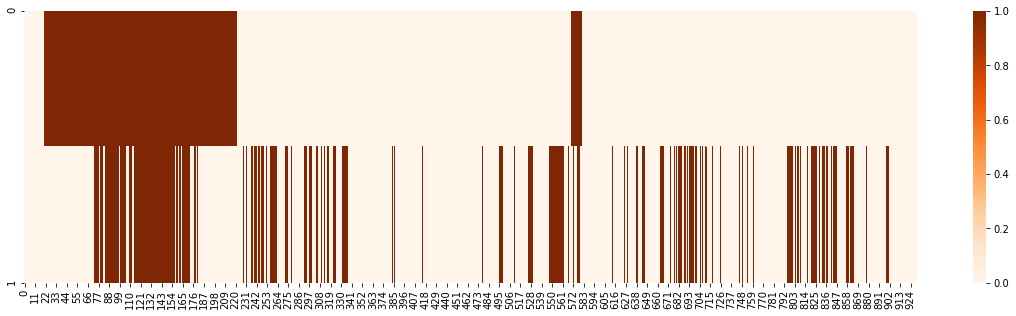

In [31]:

fig, ax = plt.subplots(figsize = (20,5))
ax = sns.heatmap(test_set[test_set['Date']== '2018-06-26'][['has_wo', 'wo_predict']].as_matrix().T, cmap = 'Oranges')
plt.show()

j:\shared\omsa\sem3\dva\lib\site-packages\ipykernel_launcher.py:4: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  after removing the cwd from sys.path.


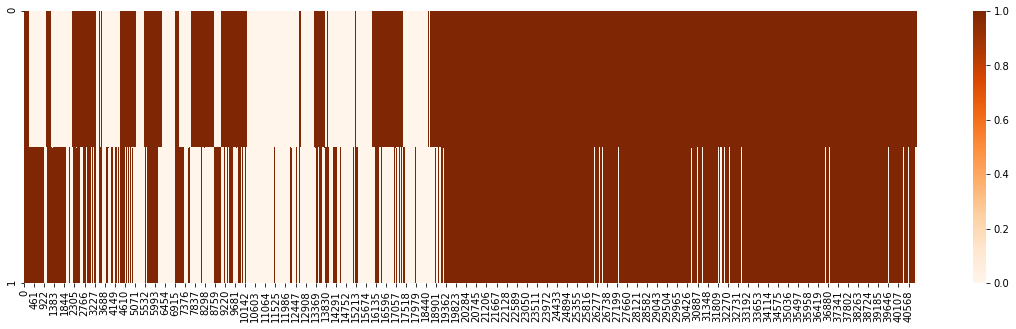

In [32]:
import matplotlib.pyplot as plt
import seaborn as sns
fig, ax = plt.subplots(figsize = (20,5))
ax = sns.heatmap(test_set[test_set['Date']== '2015-05-15'][['has_wo', 'wo_predict']].as_matrix().T, cmap = 'Oranges')
plt.show()

j:\shared\omsa\sem3\dva\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


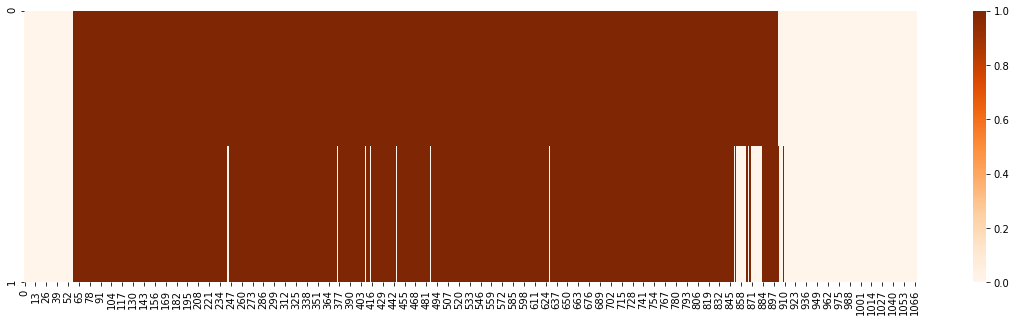

In [33]:

fig, ax = plt.subplots(figsize = (20,5))
ax = sns.heatmap(test_set[test_set['Date']== '2016-06-03'][['has_wo', 'wo_predict']].as_matrix().T, cmap = 'Oranges')
plt.show()

j:\shared\omsa\sem3\dva\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


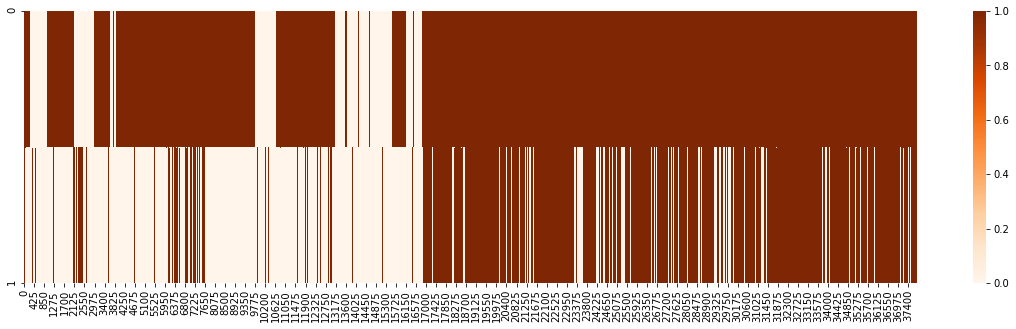

In [34]:

fig, ax = plt.subplots(figsize = (20,5))
ax = sns.heatmap(test_set[test_set['Date']== '2019-02-07'][['has_wo', 'wo_predict']].as_matrix().T, cmap = 'Oranges')
plt.show()

In [ ]:
## crossvalidation

In [35]:
## hyperparameter tuning


parameters = {'n_estimators': range(100, 200, 20), 'max_depth': range(50, 200, 50)}
rf_hpt = GridSearchCV(rf, parameters, cv = 5)
rf_hpt.fit(X_train, y_train)

NameError: name 'rf' is not defined

In [121]:
print(rf_hpt.best_params_ )
print(rf_hpt.best_score_)

{'max_depth': 150, 'n_estimators': 180}
0.8949485918641037


In [122]:
rfcv_pred = rf_hpt.predict(x_test_set)
rf_acc = metrics.accuracy_score(rfcv_pred, test_set['has_wo'])
rf_pres = metrics.precision_score(rfcv_pred, test_set['has_wo'])
rf_rec = metrics.recall_score(rfcv_pred, test_set['has_wo'])
print('accuracy {} precision {} recall {}'.format(rf_acc,rf_pres,rf_rec))

accuracy 0.7186729599484645 precision 0.7058999511880206 recall 0.9175023535671892


In [7]:
0.7058999511880206*0.9175023535671892/(0.9175023535671892+0.7058999511880206)

0.3989552464603857

In [123]:

rf_cv = metrics.confusion_matrix(rfcv_pred, test_set['has_wo'])
rf_cv

array([[13181, 18678],
       [ 4031, 44831]], dtype=int64)

In [124]:
# prepdata
rf_pred_full_cv = rf_hpt.predict(x_test_set)
rf_acc_cv = metrics.accuracy_score(rf_pred_full_cv, test_set['has_wo'])
rf_pres_cv = metrics.precision_score(rf_pred_full_cv, test_set['has_wo'])
rf_rec_cv = metrics.recall_score(rf_pred_full_cv, test_set['has_wo'])
print(rf_acc)

0.7186729599484645


In [37]:
test_set['wo_predict_cv'] = rf_pred_full

j:\shared\omsa\sem3\dva\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [126]:
for date in test_set['Date'].unique():
    print('date is {}'.format(date))
    acc = metrics.accuracy_score(test_set.loc[test_set['Date'] == date, 'has_wo'],test_set.loc[test_set['Date'] == date, 'wo_predict_cv'])
    recall = metrics.recall_score(test_set.loc[test_set['Date'] == date, 'has_wo'],test_set.loc[test_set['Date'] == date, 'wo_predict_cv'])
    precision= metrics.precision_score(test_set.loc[test_set['Date'] == date, 'has_wo'],test_set.loc[test_set['Date'] == date, 'wo_predict_cv'])
    f1 = metrics.f1_score(test_set.loc[test_set['Date'] == date, 'has_wo'],test_set.loc[test_set['Date'] == date, 'wo_predict_cv'])
    print('acc {} recall {} precision {} f1 {}'.format(acc, recall, precision, f1))

date is 2018-06-26
acc 0.677765843179377 recall 0.36792452830188677 precision 0.319672131147541 f1 0.34210526315789475
date is 2015-05-15
acc 0.7264936396708743 recall 0.723753782714243 precision 0.8825986455249605 f1 0.7953224922346063
date is 2016-06-03
acc 0.8316183348924229 recall 0.8092417061611374 precision 0.9729344729344729 f1 0.8835705045278137
date is 2019-02-07
acc 0.5665978180277513 recall 0.5191464393799025 precision 0.9547907082410405 f1 0.6725879693532578


j:\shared\omsa\sem3\dva\lib\site-packages\ipykernel_launcher.py:4: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  after removing the cwd from sys.path.


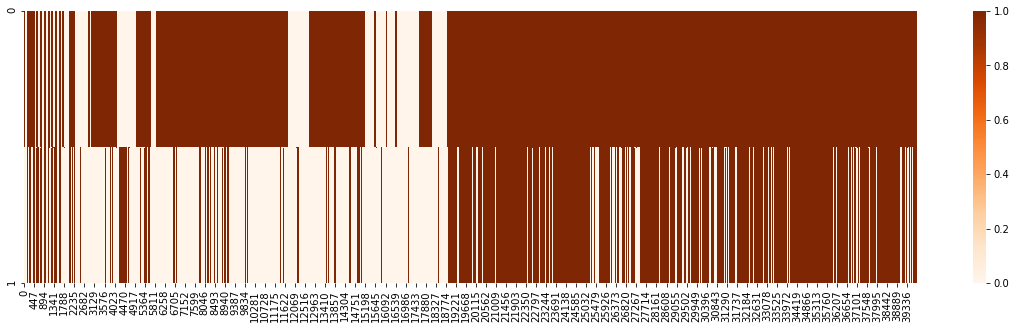

In [38]:
import matplotlib.pyplot as plt
import seaborn as sns
fig, ax = plt.subplots(figsize = (20,5))
ax = sns.heatmap(test_set[test_set['Date']!= '2015-05-15'][['has_wo', 'wo_predict_cv']].as_matrix().T, cmap = 'Oranges')
plt.show()

j:\shared\omsa\sem3\dva\lib\site-packages\ipykernel_launcher.py:4: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  after removing the cwd from sys.path.


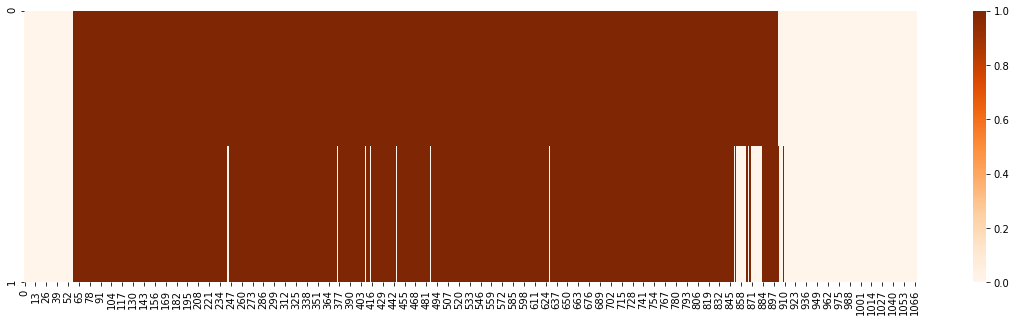

In [39]:
import matplotlib.pyplot as plt
import seaborn as sns
fig, ax = plt.subplots(figsize = (20,5))
ax = sns.heatmap(test_set[test_set['Date']== '2016-06-03'][['has_wo', 'wo_predict_cv']].as_matrix().T, cmap = 'Oranges')
plt.show()

j:\shared\omsa\sem3\dva\lib\site-packages\ipykernel_launcher.py:4: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  after removing the cwd from sys.path.


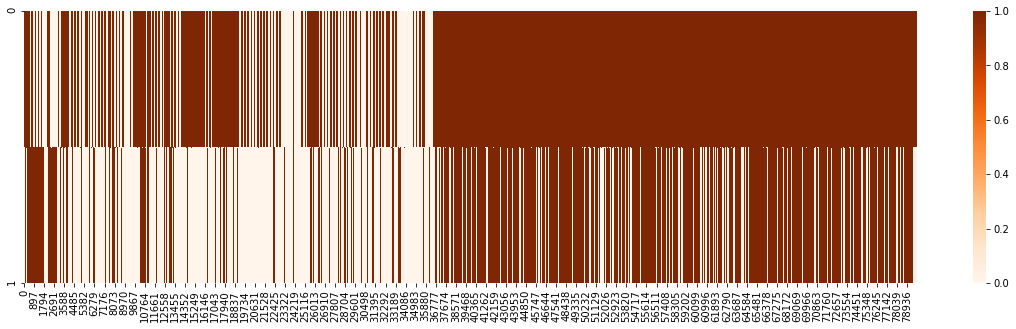

In [131]:
import matplotlib.pyplot as plt
import seaborn as sns
fig, ax = plt.subplots(figsize = (20,5))
ax = sns.heatmap(test_set[test_set['Date']!= '2018-06-26'][['has_wo', 'wo_predict_cv']].as_matrix().T, cmap = 'Oranges')
plt.show()

j:\shared\omsa\sem3\dva\lib\site-packages\ipykernel_launcher.py:4: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  after removing the cwd from sys.path.


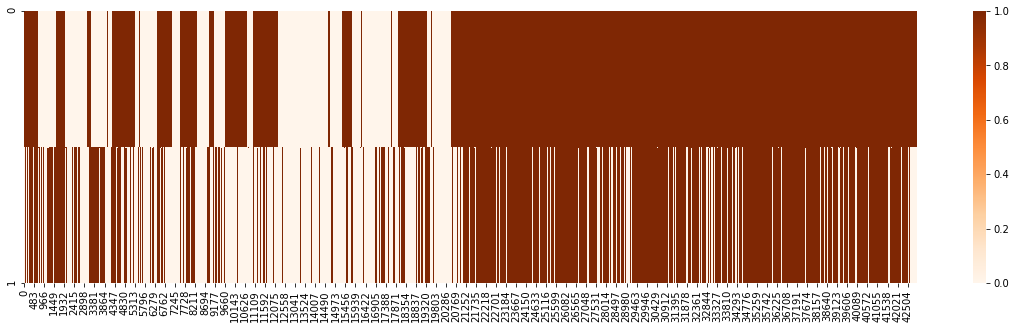

In [132]:
import matplotlib.pyplot as plt
import seaborn as sns
fig, ax = plt.subplots(figsize = (20,5))
ax = sns.heatmap(test_set[test_set['Date']!= '2019-02-07'][['has_wo', 'wo_predict_cv']].as_matrix().T, cmap = 'Oranges')
plt.show()

j:\shared\omsa\sem3\dva\lib\site-packages\ipykernel_launcher.py:4: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  after removing the cwd from sys.path.


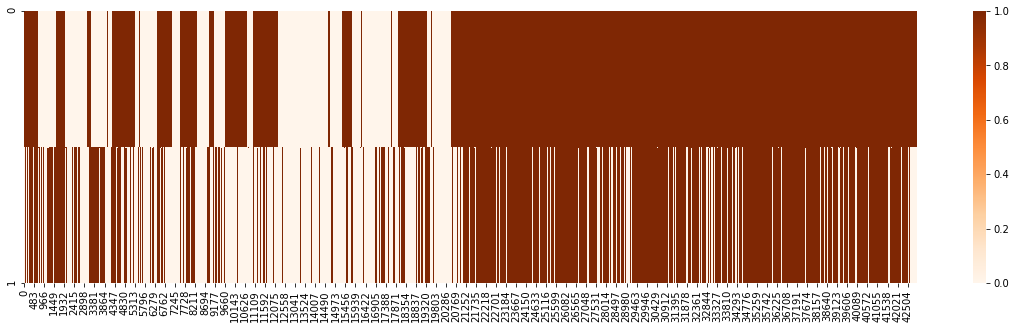

In [133]:
import matplotlib.pyplot as plt
import seaborn as sns
fig, ax = plt.subplots(figsize = (20,5))
ax = sns.heatmap(test_set[test_set['Date']!= '2019-02-07'][['has_wo', 'wo_predict_cv']].as_matrix().T, cmap = 'Oranges')
plt.show()

In [ ]:
import pickle

In [134]:
with open('rf_hpt_20nov.pickle', 'wb') as f:
    pickle.dump(rf_hpt, f)

In [119]:
## ultimate test: on 195

In [3]:
with open('rf_hpt_20nov.pickle', 'rb') as f:
    model = pickle.load(f)

In [8]:
c195 = pd.read_csv('C195_GPR_TRC_nov20/combined_195.csv')



KeyError: 'has_wo'

In [9]:
c195['has_wo'] = c195['Work_order_type'].apply(lambda x: presence_of_wo(x))

In [10]:
## now predict on holdout set
### Prep data
test195 = c195[measures]
test195_y = c195['has_wo']

for col in test195.columns:
    test195[col] = pd.to_numeric(test195[col], errors='coerce')

test195 = test195.fillna(0)

j:\shared\omsa\sem3\dva\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


In [21]:
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
rf_pred_full_cv = model.predict(test195)

In [22]:
from sklearn import metrics
rf_acc_cv = metrics.accuracy_score(rf_pred_full_cv, test195_y)
rf_pres_cv = metrics.precision_score(rf_pred_full_cv, test195_y)
rf_rec_cv = metrics.recall_score(rf_pred_full_cv, test195_y)
print(rf_acc_cv, rf_pres_cv, rf_rec_cv)

0.560685881741969 0.4369207478796765 0.1283870227650663


In [23]:
c195['wo_predict_cv'] =rf_pred_full_cv

In [24]:
for date in c195['Date'].unique():
    print('date is {}'.format(date))
    acc = metrics.accuracy_score(c195.loc[c195['Date'] == date, 'has_wo'],c195.loc[c195['Date'] == date, 'wo_predict_cv'])
    recall = metrics.recall_score(c195.loc[c195['Date'] == date, 'has_wo'],c195.loc[c195['Date'] == date, 'wo_predict_cv'])
    precision= metrics.precision_score(c195.loc[c195['Date'] == date, 'has_wo'],c195.loc[c195['Date'] == date, 'wo_predict_cv'])
    f1 = metrics.f1_score(c195.loc[c195['Date'] == date, 'has_wo'],c195.loc[c195['Date'] == date, 'wo_predict_cv'])
    print('acc {} recall {} precision {} f1 {}'.format(acc, recall, precision, f1))

date is 2014-06-23
acc 0.6898547067094495 recall 0.38620465267610216 precision 0.15019612805263824 f1 0.2162802350476017
date is 2014-10-04
acc 0.5434858135495079 recall 0.3341645885286783 precision 0.013783172186792841 f1 0.026474365306727254
date is 2016-09-09
acc 0.562763054437815 recall 0.45113478462251044 precision 0.05209670517757809 f1 0.09340685686885637
date is 2016-10-26
acc 0.5503119087038789 recall 0.44150313354465603 precision 0.3257865228725494 f1 0.3749190921886719
date is 2017-04-11
acc 0.6811991591262224 recall 0.8571428571428571 precision 0.0013745704467353953 f1 0.0027447392497712718
date is 2017-08-29
acc 0.5890233128391901 recall 0.26030613203117664 precision 0.15670755836960823 f1 0.19563836544569133
date is 2017-11-02
acc 0.5047537240564133 recall 0.4409259571597234 precision 0.16173536462763902 f1 0.23666134817983275
date is 2018-03-06
acc 0.5816242370924286 recall 0.3601766004415011 precision 0.20747711088504578 f1 0.2632886880748749
date is 2018-08-28
acc 0.69

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns
fig, ax = plt.subplots(figsize = (20,5))
ax = sns.heatmap(pd.DataFrame(rf_pred_full_cv,test195_y).reset_index().as_matrix().T, cmap = 'Oranges')
plt.show()

j:\shared\omsa\sem3\dva\lib\site-packages\ipykernel_launcher.py:4: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  after removing the cwd from sys.path.


<Figure size 2000x500 with 2 Axes>

j:\shared\omsa\sem3\dva\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


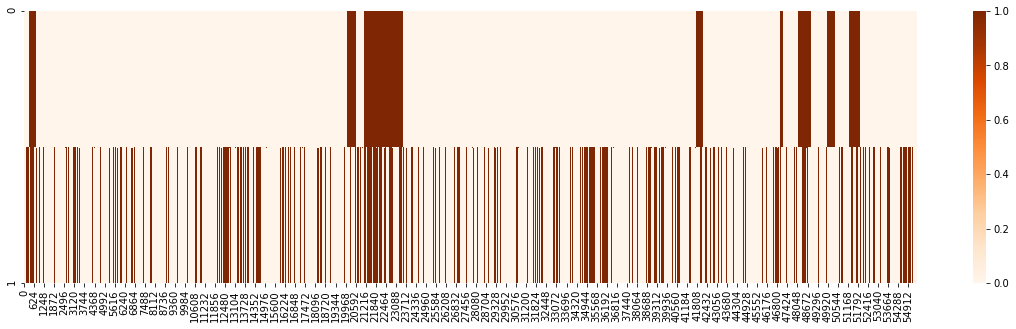

In [26]:
fig, ax = plt.subplots(figsize = (20,5))
ax = sns.heatmap(c195.loc[c195['Date'] == '2014-06-23', ['has_wo', 'wo_predict_cv']].as_matrix().T, cmap = 'Oranges')
plt.show()

j:\shared\omsa\sem3\dva\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


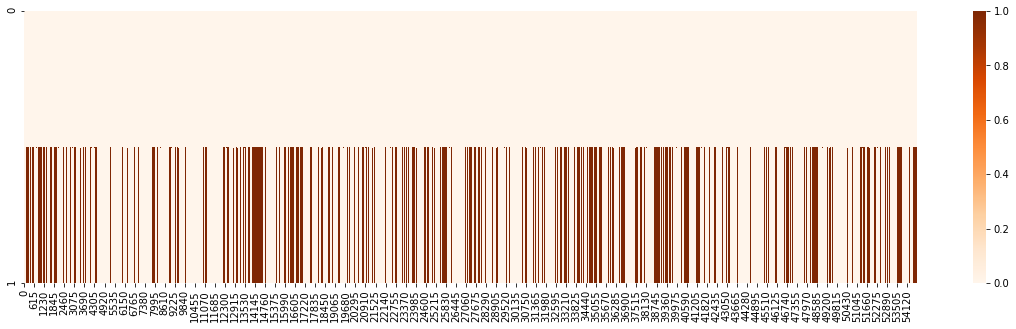

In [29]:
fig, ax = plt.subplots(figsize = (20,5))
ax = sns.heatmap(c195.loc[c195['Date'] == '2017-04-11', ['has_wo', 'wo_predict_cv']].as_matrix().T, cmap = 'Oranges')
plt.show()

In [ ]:
fig, ax = plt.subplots(figsize = (20,5))
ax = sns.heatmap(test_set[['has_wo', 'wo_predict']].as_matrix().T, cmap = 'Oranges')
plt.show()

j:\shared\omsa\sem3\dva\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


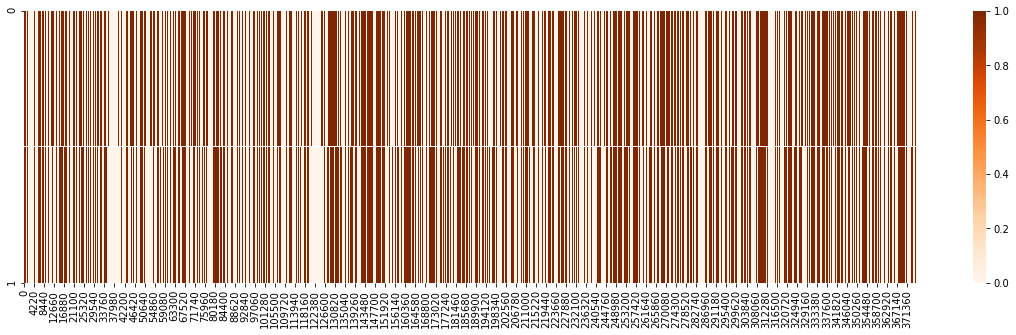

In [79]:
fig, ax = plt.subplots(figsize = (20,5))
ax = sns.heatmap(pd.DataFrame(rf_test_pred,y_test).reset_index().as_matrix().T, cmap = 'Oranges')
plt.show()


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
fig, ax = plt.subplots(figsize = (20,5))
ax = sns.heatmap(test_set[['Ballast_work', 'ballast_prediction_adj']].as_matrix().T, cmap = 'Oranges')
plt.show()